`%matplotlib notebook`을 사용하면 3D 그래프를 마우스를 사용하여 돌려볼 수 있습니다. 여기서는 `blackjack.py`와 `plotting.py` 파일을 동일한 디렉토리에 두었기 때문에 `import` 문을 조금 수정했습니다. Matplotlib은 [다양한 그래프 스타일이](https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html) 가능합니다. 스타일 목록은 `print(matplotlib.style.available)`로 확인할 수 있습니다.

In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
#from lib.envs.blackjack import BlackjackEnv
#from lib import plotting
from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

교재 5.1에 나오는 첫번째 방문 몬테카를로 예측 알고리즘입니다. 우선 경험을 수집할 자료구조를 만듭니다. `returns_sum`, `returns_count`, `V` 모두 상태를 숫자로 대응합니다. 상태는 (현재 선수가 가진 카드의 합, 딜러가 공개한 카드, 선수의 유저블 에이스 보유 여부)이고, 숫자는 부동소수점 수입니다. `defaultdict`는 기본값을 제외하고는 일반적인 딕셔너리(`{}`)와 같습니다. 즉, `defaultdict`는 없는 키에 대해서 기본값을 반환합니다. 주의할 점은 `defaultdict(0.0)`과 같이 기본값을 직접 사용하는 대신 팩토리 함수를 사용합니다. 즉, `defaultdict(float)`라고 하면, `float()`의 결과(0.0)를 기본값으로 사용합니다. 그래서 0이 아닌 기본값을 사용하려면, `defaultdict(lambda: -1.0)`같이 합니다.

`returns_sum`는 상태를 첫번째 방문한 이후 수확(return)이고, `returns_count`는 상태를 첫번째 방문한 횟수입니다. 그래서 두 값을 서로 나눈 평균값이 상태의 가치함수 값 `V`입니다.

# 1

`num_episodes`번 환경을 실행합니다. `range(num_episodes)` 대신 `range(1, num_episodes + 1)`을 사용하여 숫자를 1부터 출력합니다. `\r`은 carriage return입니다. 줄바꿈을 하면 컴퓨터는 줄 제일 앞으로 가는 carriage return과 아래 줄로 내려가는 line feed(`\n`)로 나누어 처리합니다. 오래된 터미널을 흉내내는 환경에서는 `\r`로 현재 줄 제일 앞으로 이동하고 길이가 같거나 더 긴 내용을 출력하면 앞서 출력한 내용을 덮어쓰는 효과가 있습니다.

# 2

고정된 정책(`policy`)에 따라 환경을 실행하여 (상태=관찰, 행동, 보상) 튜플을 수집합니다. `episode`는 수집한 튜플 리스트를 저장합니다.

# 3

비교적 복잡한 코드가 많이 나오는 부분입니다. 먼저 list comprehension이 많이 등장합니다. list comprehension은 `for`나 `while` 같은 반복문 역할을 합니다. 짧은 반복문을 한줄에 깔끔하게 표현할 수 있습니다. 하스켈에서 차용한 기능이지만, list comprehension을 잘 사용하면 파이썬스러운(Pythonic) 코드라고 평가합니다. list comprehension은 `[결과항목 for 항목 in 리스트]` 형태입니다. 리스트의 항목을 하나씩 처리하여 그 결과로 다시 리스트로 만듭니다. 예를 들어 `[x ** 2 for x in [2, 3, 5, 7]]`은 한자리 소수를 순서대로 제곱한 리스트입니다. 함수의 아규먼트로 사용할 때 대괄호를 생략할 수 있습니다. 그래서 `f(x ** 2 for x in [2, 3, 5, 7])`은 `f([x ** 2 for x in [2, 3, 5, 7]])`과 같습니다. (정확히는 리스트가 아니라 generator expression이지만 여기서는 차이를 무시합니다.) list comprehension에서 `if`를 사용하면, 리스트에서 특정 조건을 만족하는 항목만 (filter) 처리하여 결과 리스트에 넣습니다. 예를 들어, `[x ** 2 for x in [2, 3, 5, 7] if x % 2 != 0]`은 리스트에서 홀수만 제곱합니다.

`set([tuple(x[0]) for x in episode])`은 `episode` 리스트에서 상태만 집합으로 만듭니다. `x[0]`은 (상태, 행동, 보상) 튜플의 첫번째 항목, 즉 상태를 뜻합니다. `x.state`같이 코드를 더 알아보기 쉽게 만들기위해 `namedtuple`이나 NumPy 필드명을 추천합니다. `(xxx)`처럼 항목이 한개인 튜플을 (여러가지 의미로 해석할 수 있어서 파이썬이 이해할 수 없기 때문에 `tuple(xxx)` 혹은 `(xxx,)`을 사용합니다. 마지막으로 `set()` 함수는 리스트를 (중복이 없는) 집합으로 만듭니다. list comprehension의 변형이 set comprehension을 사용해도 됩니다. 즉, `{tuple(x[0]) for x in episode}`

상태 집합에서 상태를 한개씩 가져와 처리합니다.

`next(i for i,x in enumerate(episode) if x[0] == state)`를 살펴봅시다. list comprehension을 함수(`next`)의 아규먼트로 사용하여 대괄호를 삭제한 형태입니다. 즉, 아규먼트는 `[i for i,x in enumerate(episode) if x[0] == state]`입니다. 여기서 `episode` 리스트를 그대로 사용하지 않고, `enumerate(episode)`를 사용합니다. `enumerate()`는 리스트에 순번을 포함합니다. 즉, `enumerate(['apple', 'melon', 'orange'])`는 `[(0, 'apple'), (1, 'melon'), (2, 'orange')]`가 됩니다. 앞에 `i,x`에서 `i`는 순번, `x`는 (상태, 행동, 보상) 튜플이 됩니다. `if x[0] == state` 조건은 상태(튜플의 첫번째 항목)가 우리가 원하는 상태인 항목만 남깁니다. 그러면 `[i`에서 순번을 결과 리스트에 포함합니다. 종합하여 아규먼트는 에피소드에서 우리가 원하는 상태가 있는 순번 리스트입니다. 모든 방문 (every visit) 몬테카를로에 적합한 자료입니다. `next(iterator)`는 함수를 호출할 때마다 반복자(iterator)에서 다음 순서 항목을 반환합니다. 리스트도 반복자에 속하고, `next()` 함수를 처음 호출하면 첫번째 항목을 반환합니다. 그래서 전체는 우리가 원하는 상태를 첫번째 방문한 순번을 뜻합니다. 첫번째 방문 (first visit) 몬테카를로에 해당합니다. 단순하게 `[i for i,x in enumerate(episode) if x[0] == state][0]` 혹은 `episode`를 수집할 때 상태별 첫번째 방문 순번을 기록하는 편이 더 좋아보입니다.

`sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])`은 수확을 계산합니다. list comprehension 아규먼트를 보면, `episode[first_occurence_idx:])`는 상태를 첫번째 방문한 이후 (상태, 행동, 보상) 튜플 리스트이고, `enumerate()`을 사용하여 (순번, 튜플)로 변환합니다. `x[2]*(discount_factor**i)`는 보상에 할인율을 곱합니다. 할인율을 적용한 보상 리스트를 모두 더하면(`sum()`) 수확이 됩니다. 모든 상태마다 보상 리스트를 계산하는 대신 `episode`를 뒤부터 할인율을 적용한 보상을 미리 계산하면 계산량을 줄일 수 있습니다.

In [3]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)

    ###< 1 >###
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        ###< 2 >###
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        ###< 3 >###
        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V  

카드 합이 20 이상일 때만 멈추는(stick) 단순한 고정 정책을 사용합니다.

In [4]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

Episode 10000/10000.

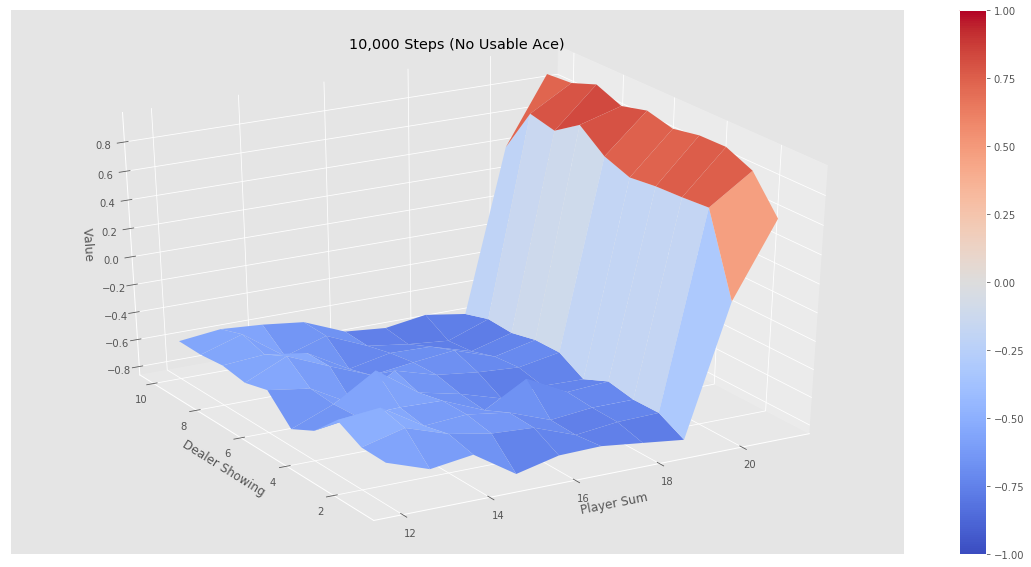

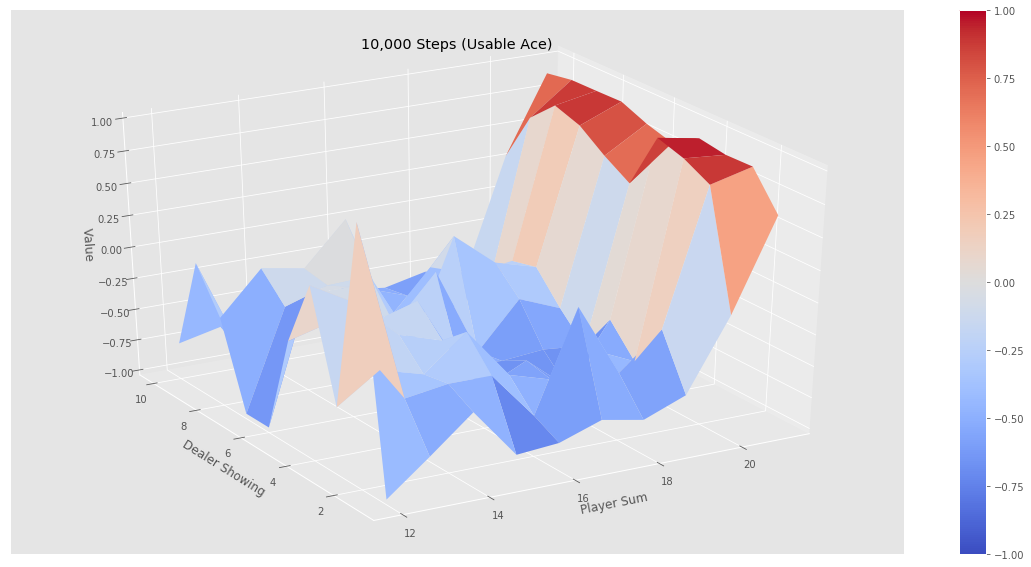

Episode 500000/500000.

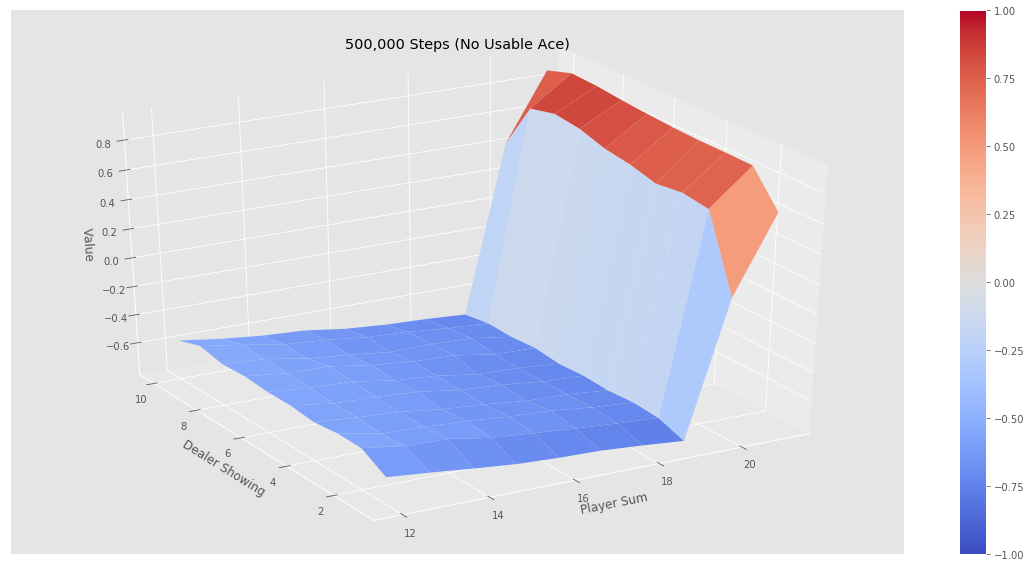

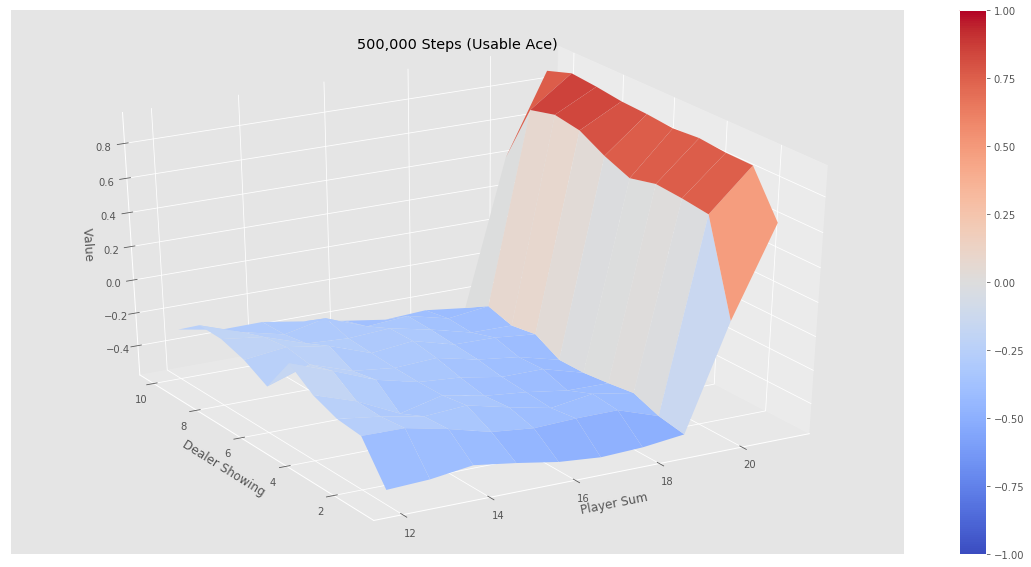

In [5]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")